In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mmcv
import cv2
from collections import Counter
import numpy as np
import lap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### OCR

In [2]:
ocr = json.load(open('/media/data_disc/data/videos2/2021_01_20_Colorado_at_Washington/2021_01_20_Colorado_at_Washington_ocr.json'))

# ocr = json.load(open('/home/ubuntu/oljike/data/videos1/ocr_results/results/ocr_with_gameclockrunning/2020_01-20_NCState_at_Virginia/2020_01-20_NCState_at_Virginia_ocr.json'))

In [3]:
l = None
cnt = 0
for k, v in ocr['results'].items():
    if ocr['results'][k]['score_bug_present'] and ocr['results'][k]['game_clock_running']:
        cnt+=1
        l = k
print(cnt, len(ocr['results']), l)

69153 172920 170983


### Players Stats Main

In [4]:
csv_path = './demos/custom_5vals_colors_all_30ep_data2_50ep/2021_01_20_Colorado_at_Washington_orig.csv'
tracking_path = './demos/custom_5vals_colors_all_30ep_data2_50ep/2021_01_20_Colorado_at_Washington.json'
pl_time = pd.read_csv('./demos/custom_5vals_colors_all_30ep_data2_50ep/2021_01_20_Colorado_at_Washington_time.csv')

# csv_path = './demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.csv'
# tracking_path = './demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.json'
# player_time = './demos/custom_5vals_colors_all_30ep_debug/player_time.csv'
# pl_time = pd.read_csv(player_time)

In [5]:
def get_players(pl_time):

#     players = pd.read_csv(path)
    
    teams = pl_time['team'].unique()
    
    players1 = pl_time.loc[pl_time['team'] == teams[0]]['jersey_number'].tolist()
    players1 = set([str(x) for x in players1])

    players2 = pl_time.loc[pl_time['team'] == teams[1]]['jersey_number'].tolist()
    players2 = set([str(x) for x in players2])
    
    teams_dct = []
    teams_dct.append((players1, 0))
    teams_dct.append((players2, 1))
    
    
    return players1, players2, teams, teams_dct
players1, players2, teams, teams_dct  = get_players(pl_time)

### Read jersey tracking info

In [6]:
tracking = json.load(open(tracking_path))
print("Number of active frames ", len(tracking), )

Number of active frames  69153


In [7]:
def get_cnt(tracking):

    team_1 = []
    team_2 = []
    cnt = 0
    for k, v in tracking.items():
        for el in v:
            curr_el = el.split(',')
            if curr_el[-2] == '0.0':
                team_1.append(curr_el[-1])
            elif curr_el[-2] == '1.0':
                team_2.append(curr_el[-1])
            cnt += 1
        
    print("Team balance {} / {}".format(len(team_1), len(team_2)))
    cnt_1 = Counter(team_1)
    cnt_2 = Counter(team_2)
    
    return cnt_1, cnt_2
cnt_1, cnt_2 = get_cnt(tracking)

Team balance 488659 / 349246


#### Remove non-existing jersey numbers


In [8]:
def remove_nonex(cnt, players1, players2):
    
    for k in list(cnt):
        if k=='None': 
            cnt.pop(k, 'None')
        elif k not in players1 and k not in players2:
            cnt.pop(k, 'None')

    return cnt

cnt_1 = remove_nonex(cnt_1, players1, players2)
cnt_2 = remove_nonex(cnt_2, players1, players2)

#### Calculate Histogram Loss

In [9]:
def calc_hist_loss(cnt, players1, players2):
    
    max_ = max(list(cnt.values()))
    min_ = min(list(cnt.values()))
    loss_1 = 0
    loss_2 = 0
    for k, v in cnt.items():

        curr_val = (int(v) - min_)/(max_ - min_)       
        if k in players1 and k in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1 - curr_val           
        elif (k) in players1 and (k) not in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1
        elif (k) not in players1 and (k) in players2:
            loss_1 += 1
            loss_2 += 1 - curr_val
        elif (k) not in players1 and (k) not in players2:
            loss_1 += 1
            loss_2 += 1
            
    return loss_1, loss_2

In [10]:
cnt1_l1, cnt1_l2 = calc_hist_loss(cnt_1, players1, players2)
cnt2_l1, cnt2_l2 = calc_hist_loss(cnt_2, players1, players2)

In [11]:
def get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2):

    cost_matrix = np.array([[cnt1_l1, cnt1_l2], [cnt2_l1, cnt2_l2]])
    print(cost_matrix)
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches)
    
    if matches[0][1] == 0:
        pair1 = (cnt_1, players1)
        pair2 = (cnt_2, players2)
    elif matches[0][1] == 1:
        pair1 = (cnt_1, players2)
        pair2 = (cnt_2, players1)
        
    return pair1, pair2

pair1, pair2 = get_cost(cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2)

[[10.63554825 12.86987974]
 [12.19882148 10.70461747]]


### Calculate stats for each player

In [25]:
def get_stats_minutes(cnt, players, length=len(tracking)):   
    res = {}
    for k, v in cnt.items():
        if k in players:
#             res[k] = str(round(100 * (v / length), 2)) + '%'  
            res[k] = str(round(v / 25 / 60, 2)) + 'min'  
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

if pair1[1] in teams_dct[0]:
    print(str(teams[0]), get_stats_minutes(pair1[0], pair1[1]))
    print(str(teams[1]), get_stats_minutes(pair2[0], pair2[1]))
elif pair1[1] in teams_dct[1]:
    print(str(teams[1]), get_stats_minutes(pair1[0], pair1[1]))
    print(str(teams[0]), get_stats_minutes(pair2[0], pair2[1]))

Colorado {'13': '8.29min', '12': '7.16min', '11': '67.56min', '5': '38.34min', '24': '32.06min', '25': '24.58min', '3': '22.77min', '21': '21.65min', '41': '13.21min'}
Washington {'22': '5.12min', '5': '34.71min', '0': '27.91min', '1': '26.05min', '10': '19.67min', '13': '18.58min', '55': '17.08min', '52': '0.72min'}


In [26]:
def get_stats_percentage(cnt, players, pl_time, teams, ocr):   
        
    if players in teams[0]:
        idx = teams[0][1]
    else:
        idx = teams[1][1]
    
    teams = pl_time['team'].unique()
    time_info = pl_time.loc[pl_time['team'] == teams[idx]][['minutes_int', 'jersey_number']]
    
    res = {}
    for row in time_info.iterrows():
        player = str(int(row[1][1]))
        
        if player in players:
            res[player] = str(round(100 * (cnt[player] / ocr['video_fps'] / 60) / float(row[1][0]), 2)) + '%'
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

if pair1[1] in teams_dct[0]:
    print(str(teams[0]), get_stats_percentage(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[1]), get_stats_percentage(pair2[0], pair2[1], pl_time, teams_dct, ocr)) 
elif pair1[1] in teams_dct[1]:
    print(str(teams[1]), get_stats_percentage(pair1[0], pair1[1], pl_time, teams_dct, ocr))
    print(str(teams[0]), get_stats_percentage(pair2[0], pair2[1], pl_time, teams_dct, ocr))

Colorado {'24': '95.14%', '3': '81.91%', '25': '65.72%', '21': '60.51%', '13': '59.58%', '12': '52.86%', '11': '448.57%', '41': '40.32%', '5': '127.62%'}
Washington {'0': '87.7%', '22': '81.57%', '1': '81.16%', '5': '75.33%', '13': '69.29%', '10': '52.35%', '52': '4.53%', '55': '39.35%'}


### Visual

In [24]:
video = mmcv.VideoReader('./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4')

In [27]:
frame = video.get_frame(50000)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

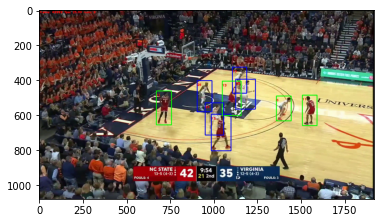

In [28]:
plt.imshow(frame)

colorado - black forma
washington - white form



GROUND TRUTH:
blue  - colorado - 0.0
green - washington - 1.0

PREDICTION:
0.0 - COLORADO
1.0 - WASHINGTON

RESULT:
    TRUE!

In [34]:
!aws s3 cp ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 s3://boost-operators-data/tracking_results/

upload: demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4 to s3://boost-operators-data/tracking_results/2020_01-20_NCState_at_Virginia.mp4


In [35]:
!rm ./demos/custom_5vals_colors_all_30ep_debug/2020_01-20_NCState_at_Virginia.mp4

In [23]:
import src._init_paths
import src.lib.datasets.dataset.jde as datasets

In [26]:
input_video = '/media/data_disc/data/videos2/2021_01_20_Colorado_at_Washington/2021_01_20_Colorado_at_Washington.mp4'
dataloader = datasets.LoadVideo(input_video, (1088, 608))

valid_frames = set()
for i in range(len(dataloader)):
    curr_data = ocr['results'][str(i)]

    if curr_data['score_bug_present'] and curr_data['game_clock_running']:

        valid_frames.add(i)

        

Lenth of the video: 172920 frames


In [27]:
results = json.load(open('./demos/custom_5vals_colors_all_30ep_data2_50ep/magazine/2021_01_20_Colorado_at_Washington.json'))

In [46]:
tlwhs = []
for i in range(len(dataloader)):
    if str(i) not in results:
        tlwhs.append([])
    else:
        curr_hist = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_hist.append(line[1:5])
        tlwhs.append(curr_hist) 

In [47]:
tlwhs[871][0]

['0.7506660461425781',
 '0.5294657389322917',
 '196.460205078125',
 '425.45318603515625']

In [32]:
all_hists = []
for i in range(len(dataloader)):
    if str(i) not in results:
        all_hists.append([])
    else:
        curr_hist = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_hist.append(line[-2])
        all_hists.append(curr_hist) 

In [34]:
all_jerseys = []
for i in range(len(dataloader)):
    if str(i) not in results:
        all_jerseys.append([])
    else:
        curr_jer = []
        for x in results[str(i)]:
            line = x.split(',')
            curr_jer.append(line[-1])
            
        all_jerseys.append(curr_jer)

In [30]:
results['871']

['1,0.7506660461425781,0.5294657389322917,196.460205078125,425.45318603515625,0.0,55',
 '2,0.8631458918253581,0.1757689016836661,104.443115234375,270.4006042480469,1.0,None',
 '3,0.40824549992879233,0.46805312545211225,160.6307373046875,401.691650390625,1.0,24',
 '4,0.5262829462687174,0.4294441505714699,148.1846923828125,357.78277587890625,0.0,10',
 '5,0.15809319814046224,0.7213876794885706,184.145263671875,466.08587646484375,0.0,10',
 '6,0.7384349187215169,0.30305766352900754,143.103759765625,306.2678527832031,1.0,None',
 '7,0.36453307469685875,0.4110870361328125,143.248046875,355.74041748046875,0.0,1',
 '8,0.44318790435791017,0.23128238254123265,110.7904052734375,275.8504638671875,1.0,None',
 '9,0.4589625358581543,0.34071923715096936,121.881591796875,308.7441101074219,0.0,None']

In [28]:
output_video = './demos/custom_5vals_colors_all_30ep_data2_50ep/magazine/2021_01_20_Colorado_at_Washington.mp4'

In [97]:
def get_color_team(cls):
    if cls=='0.0':
        return (255,0,0)
    elif cls=='1.0':
        return (0,255,0)
    
    
dataloader.re_init()
valid = 0
frame_id = 0

### Write to video
img_h, img_w = (1080, 1920)
text_scale = max(1, img0.shape[1] / 1600.)
out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'MP4V'), dataloader.frame_rate, (img_w, img_h))

jersey = None
ball = None
for i, (path, img, img0) in enumerate(tqdm(dataloader)):
    if valid >= len(results) or i>1000: break
    curr_data = ocr['results'][str(i)]

    if curr_data['score_bug_present'] and curr_data['game_clock_running']:

        if i in valid_frames:
            online_tlwhs = tlwhs[i]
            cls = all_hists[i]
            jersey = all_jerseys[i]

            for ii, tlwh in enumerate(online_tlwhs):
                x1, y1, w, h = [float(x) for x in tlwh]
                intbox = tuple(map(int, (x1*img_w, y1*img_h, (x1*img_w + w), (y1*img_h + h))))
                color = get_color_team(cls[ii])
                cv2.rectangle(img0, intbox[0:2], intbox[2:4], color=color, thickness=1)

                if jersey:
                    jersey_id = str(jersey[ii])
                    cv2.putText(img0, jersey_id, (intbox[0], intbox[1] + 30), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                            thickness=1)

        valid += 1
        
    out.write(img0)
    frame_id += 1





out.release()

In [93]:
len(ocr['results'])

172920

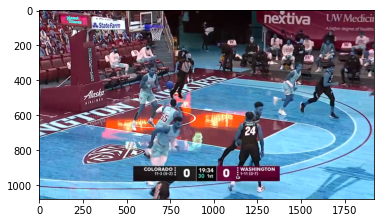

In [84]:
plt.imshow(img0)